<a href="https://colab.research.google.com/github/leungstephanie/2024-create-a-thon/blob/main/team_cre8_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yoga Posture Code

In [15]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models
from tensorflow.keras import Model
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [10]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-08-07 22:35:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-07 22:35:15 (52.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [11]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
data = '/content/drive/MyDrive/Yoga Postures Dataset/'

Mounted at /content/drive


In [122]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.jpeg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [123]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Yoga Postures Dataset/B...,Chair Pose
1,/content/drive/MyDrive/Yoga Postures Dataset/B...,Chair Pose
2,/content/drive/MyDrive/Yoga Postures Dataset/B...,Lotus Pose
3,/content/drive/MyDrive/Yoga Postures Dataset/B...,Lotus Pose
4,/content/drive/MyDrive/Yoga Postures Dataset/B...,Lotus Pose
...,...,...
761,/content/drive/MyDrive/Yoga Postures Dataset/B...,Lotus Pose
762,/content/drive/MyDrive/Yoga Postures Dataset/B...,Lotus Pose
763,/content/drive/MyDrive/Yoga Postures Dataset/I...,Extended Hand-to-Big-Toe Pose
764,/content/drive/MyDrive/Yoga Postures Dataset/I...,Extended Hand-to-Big-Toe Pose


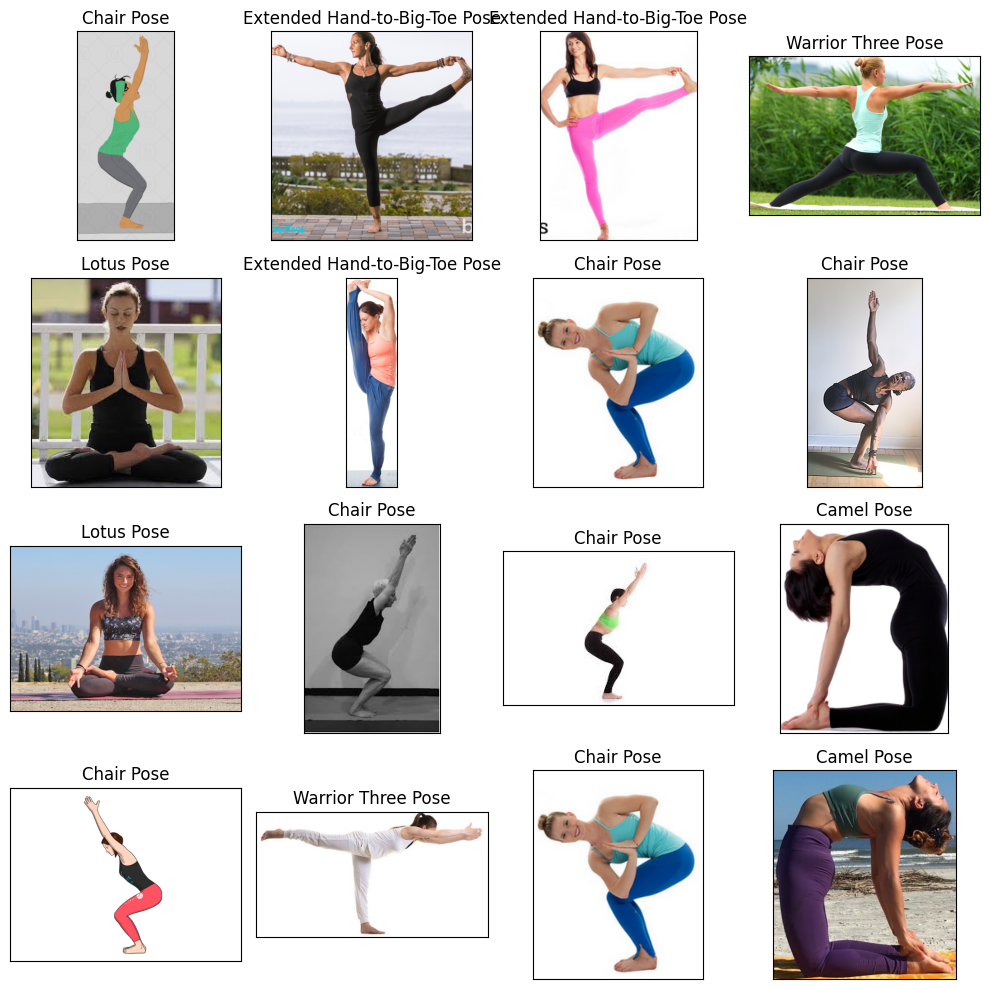

In [124]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (10,10), subplot_kw = {'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [125]:
train_df, test_df = train_test_split(image_df, test_size = 0.2, shuffle = True, random_state = 42)

In [126]:
train_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input, validation_split = 0.2)
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input)

In [127]:
# Split data into train, validation and test set

train_images = train_gen.flow_from_dataframe(dataframe = train_df,
                                            x_col = 'Filepath',
                                            y_col = 'Label',
                                            target_size = (224,224),
                                            color_mode = 'rgb',
                                            class_mode = 'categorical',
                                            batch_size = 32,
                                            shuffle = True,
                                            seed = 42,
                                            subset = 'training')

val_images = train_gen.flow_from_dataframe(dataframe = train_df,
                                            x_col = 'Filepath',
                                            y_col = 'Label',
                                            target_size = (224,224),
                                            color_mode = 'rgb',
                                            class_mode = 'categorical',
                                            batch_size = 32,
                                            shuffle = True,
                                            seed = 42,
                                            subset = 'validation')

test_images = test_gen.flow_from_dataframe(dataframe = test_df,
                                            x_col = 'Filepath',
                                            y_col = 'Label',
                                            target_size = (224,224),
                                            color_mode = 'rgb',
                                            class_mode = 'categorical',
                                            batch_size = 32,
                                            shuffle = False)

Found 490 validated image filenames belonging to 5 classes.
Found 122 validated image filenames belonging to 5 classes.
Found 154 validated image filenames belonging to 5 classes.


In [128]:
#Data Augmentation

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224,224),
    layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name = 'data_augmentation')

In [129]:
# Load pretrained Model

pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (224,224,3),include_top = False, weights = 'imagenet', pooling = 'avg')
pretrained_model.trainable = False

In [131]:
# Create checkpoint callback
checkpoint_path = "yoga_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [132]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5,
                                                  restore_best_weights=True)
# if val loss decreases for 3 epochs in a row, stop trainin

In [134]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)

outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=32,
    validation_data=val_images,
    validation_steps=32,
    epochs=30,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20240807-190936
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/32 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2001 - loss: 1.8025

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 971ms/step - accuracy: 0.1970 - loss: 1.8119 - val_accuracy: 0.2705 - val_loss: 1.6480
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 903ms/step - accuracy: 0.2177 - loss: 1.7374 - val_accuracy: 0.2869 - val_loss: 1.5985
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 900ms/step - accuracy: 0.2250 - loss: 1.6517 - val_accuracy: 0.3033 - val_loss: 1.5596
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 871ms/step - accuracy: 0.2710 - loss: 1.6348 - val_accuracy: 0.3197 - val_loss: 1.5289
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 998ms/step - accuracy: 0.2820 - loss: 1.5971 - val_accuracy: 0.3443 - val_loss: 1.4961
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 845ms/step - accuracy: 0.2853 - loss: 1.5272 - val_accuracy: 0.3689 - val_loss: 1.4677
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 875ms/step - accuracy: 0.3331 - loss: 1.5102 - val_accuracy: 0.3934 - val_loss: 1.4390
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 888ms/step - accuracy: 0.3784 - loss: 1.4706 - val_accuracy: 0.434

In [135]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.96064
Test Accuracy: 75.97%


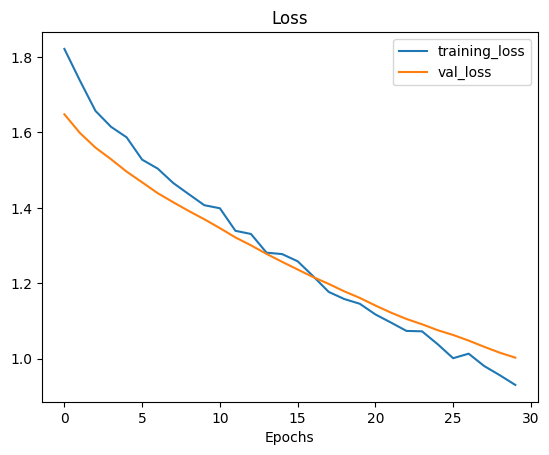

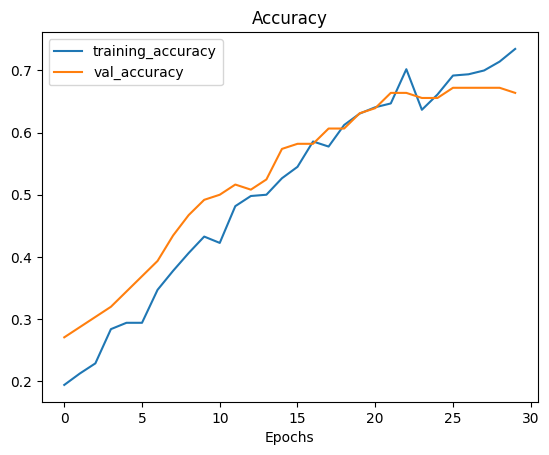

In [136]:
plot_loss_curves(history)

In [138]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [139]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                               precision    recall  f1-score   support

                   Camel Pose       0.74      0.89      0.81        45
                   Chair Pose       0.85      0.76      0.80        29
Extended Hand-to-Big-Toe Pose       0.75      0.48      0.59        25
                   Lotus Pose       0.85      0.76      0.80        29
           Warrior Three Pose       0.66      0.81      0.72        26

                     accuracy                           0.76       154
                    macro avg       0.77      0.74      0.74       154
                 weighted avg       0.77      0.76      0.75       154



# Age Predictor Model

In [3]:
# Imports
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
import cv2
# import os
from zipfile import ZipFile
# import time
# from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [12]:
age_predictor =  load_model('/content/drive/MyDrive/Colab Notebooks/age_model_acc_0.825.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [13]:
age_predictor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 48, 48, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 23, 23, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 10, 10, 256)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 132)                 │          33,924 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             931 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,697 (1.61 MB)

 Trainable params: 422,695 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

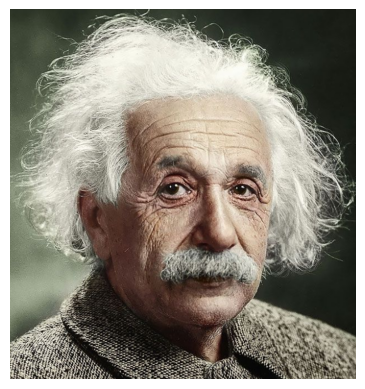

In [16]:
# Open an image file
image_path = '/content/drive/MyDrive/Colab Notebooks/Einstein_profile.png'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

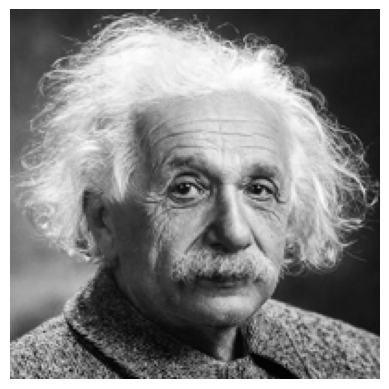

In [20]:
image_resized = image.resize((200,200))
image_processed = image_resized.convert('L')  # 'L' mode is for grayscale
plt.imshow(image_processed, cmap='gray')
plt.axis('off')
plt.show()

In [22]:
np.size(image_processed)

(200, 200)

In [24]:
prediction  =  age_predictor.predict(np.array(image_processed).reshape(1,200,200,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


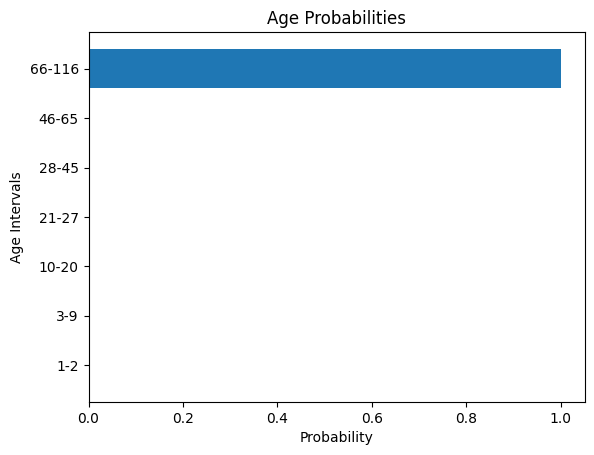

In [28]:
age_intervals = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
plt.barh(age_intervals, prediction[0])
plt.xlabel('Probability')
plt.ylabel('Age Intervals')
plt.title('Age Probabilities')
plt.show()